In [1]:
import csv
from collections import  defaultdict,Counter
import pandas as pd
import numpy as np
from random import random,choice,randint,uniform
import heapq


In [2]:

with open('studentCourse.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    d = defaultdict(list)
    dict2 = defaultdict(list)
    for row in csv_reader:
        if line_count != 0:
            d[row[1]].append(row[2])
            dict2[row[2]].append(row[1])   
        line_count += 1


# all student names       
students = list(d.keys())
# list of all courses  
courses = list(dict2.keys())


teachers = set()
with open('teachers.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      teachers.add(row[0])

# list of all teachers 
teachers = list(teachers)


# list of all rooms
rooms = ['1','2','3','4','5','6','7','8','9','10']

num_rooms = len(rooms)
num_students = len(students)
num_teachers = len(teachers)
num_courses = len(courses)



days = 5 
num_slots_in_day = 2
time = ['Monday    \tSection A 9AM-12PM','Monday    \tSection A 2PM-5PM','Tuesday   \tSection A 9AM-12PM','Tuesday   \tSection A 2PM-5PM','Wednesday \tSection A 9AM-12PM',
        'Wednesday \tSection A 2PM-5PM','Thursday  \tSection A 9AM-12PM','Thursday  \tSection A 2PM-5PM','Friday    \tSection A 9AM-12PM','Friday    \tSection A 2PM-5PM',
        #second weeek
        'Monday    \tSection B 9AM-12PM','Monday    \tSection B 2PM-5PM','Tuesday   \tSection B 9AM-12PM','Tuesday   \tSection B 2PM-5PM','Wednesday \tSection B 9AM-12PM',
        'Wednesday \tSection B 2PM-5PM','Thursday  \tSection B 9AM-12PM','Thursday  \tSection B 2PM-5PM','Friday    \tSection B 9AM-12PM','Friday    \tSection B 2PM-5PM',
        #third week
        'Monday    \tSection C 9AM-12PM','Monday    \tSection C 2PM-5PM',
        'Tuesday   \tSection C 9AM-12PM','Tuesday   \tSection C 2PM-5PM' #,'Wednesday \tSection C 9AM-12PM','Wednesday \tSection C 2PM-5PM',
        #'Thursday  \tSection C 9AM-12PM','Thursday  \tSection C 2PM-5PM','Friday    \tSection C 9AM-12PM','Friday    \tSection C 2PM-5PM'
        
        ]




**Miscellaneous for fitness function**

In [3]:

# FUNCTION TO CHECK THAT GIVEN TWO TIMESLOTS ARE CONSECUTIVE or not (on same day)
def consecutive_slots(time1,time2):
  set1 = set(time1.split(' '))
  set2 = set(time2.split(' '))
  x = set1.symmetric_difference(set2)
  if x == {'2PM-5PM', '9AM-12PM'}:
    return True
  return 0

# decaring two dictionaries
clashes = {}
clash_free = {}

# setting their keys with courses and setting values with empty lists
for i in courses:
  clashes[i] = []
  clash_free[i] = []

# dict2 is the dictionary with subject as key and students as values
# d is the dictionary with student as key and subjects as values 
# from these two dictionaries we made the deictionary clashes
# clashes has subject as key and its value is the list that contains all other subjects which its students are studying
# for example  if Ali is taking NLP , AI , PDC , ALGO
# then clashes['NLP'] = [AI,PDC,ALGO,NLP]
# similarly clashes['AI'] = [PDC,NLP,ALGO,AI]
# if we want to check number of clashes of subject X then 
# number of clashes of X = len(clashes['X']) - 1 (-1 because the name of the subject is also in the list)


for std in students:
  for course in courses:
    if std in list(dict2[course]):
      if course in list(clashes.keys()):
       for x in list(d[std]):
         if x not in list(clashes[course]):
           clashes[course].append(x)

# taking difference between set of courses and set of clashes per subject  
# by taking this difference we also deleted the name of subject itself 
# and clash_free just has the list with name of subject which is clash free with it

for i,j in clashes.items():
  clash_free[i] = list(set(courses).symmetric_difference(set(clashes[i])))



# **Chromosome** : *time_slot* : course , Room , Teacher , Time


In [4]:
class Course_Slot(object):
  def __init__(self,rooms,teachers,time,courses='-'):
    self.room = rooms
    self.course_teacher = teachers
    self.time = time
    self.course = courses
    self.done = False 

  def __repr__(self):
      return str('{:10s} {:30s} {:5s} {:30s}'.format(self.course,self.course_teacher,self.room,self.time))

#############################################################################################
course_list = []

class chromosome():
  def __init__(self):
    self.timetable  = [Course_Slot(choice(rooms),choice(teachers),choice(time)) for j in range(len(courses))]
    for exam in self.timetable:
        selected_course = choice(courses) 
        while True:
          if selected_course not in course_list:
            course_list.append(selected_course)
            if len(course_list) == len(courses):
              course_list.clear()
            break
          else:
            selected_course = choice(courses)
        exam.course = selected_course
    self.fitness = 0
    self.assigned_rooms = set()
    self.assigned_teachers = set()
    
    for i in range (len(courses)):
      self.assigned_teachers.add(self.timetable[i].course_teacher)
      self.assigned_rooms.add(self.timetable[i].room)
    
    self.clashfree = False
    self.CLASH_TEACHER = 0
    self.UNBALANCE_DUTY = 0
    self.ROOM_CLASH = 0
    self.CONSECUTIVE_DUTY = 0
    self.CLASH_TIME = 0
    


  def __repr__(self):
    fitness = "Fitness :- " + str(self.fitness) + '\n'
    label = str('{:10s} {:30s} {:5s} {:30s} '.format('Course','course_teacher','Room','Day \t\tWeek-StartHours-Endhours'))    
    startline  = "+==========================================================================================+\n"
    temp = str()
    for i in self.timetable:
      temp+=str(i)
      temp+='\n'
    endline = "+==========================================================================================+\n"
    return str(fitness + label+'\n'+startline+ temp + endline)

  def calculate_fitness(self):
    self.CLASH_TEACHER = 0
    self.UNBALANCE_DUTY = 0
    self.ROOM_CLASH = 0
    self.CONSECUTIVE_DUTY = 0
    self.CLASH_TIME = 0
    for i in range(len(self.timetable)):
      for j in range(i+1,len(self.timetable)):
        if self.timetable[i].time == self.timetable[j].time:
          if self.timetable[i].course not in clash_free[self.timetable[j].course]:
            self.CLASH_TIME +=1
            # print("CLASH TIME",end="->")
            # print(self.timetable[i].course,self.timetable[j].course)
            # constraint checking for no two exams at same time
          if self.timetable[i].room == self.timetable[j].room:
            # print("ROOM CLASH",end="->")
            # print(self.timetable[i].room,self.timetable[j].course)
            # # constraint checking for no two exams in same room
            self.ROOM_CLASH +=1
        if self.timetable[i].course_teacher == self.timetable[j].course_teacher:
          # print("UNBALANCE DUTY " , end='->')
          # print(self.timetable[i].course_teacher)
          self.UNBALANCE_DUTY +=1
          # constraint checking for teachers duty should be divided equally
          if self.timetable[i].time == self.timetable[j].time:
            # constraint checking : A teacher cannot invigilate two exams at the same time.
            self.CLASH_TEACHER +=1
            # print("CLASH TEACHER" , end='->')
            # print(self.timetable[i].course_teacher,self.timetable[j].course_teacher)
          if (consecutive_slots(self.timetable[i].time,self.timetable[j].time)):
            # print("CONSECUTIVE DUTY" , end='=>')
            # print(self.timetable[i].course_teacher,self.timetable[j].course_teacher)
            # # constraint checking that teacher should not be invigilating for two consecutive slots in arow
            self.CONSECUTIVE_DUTY +=1
      #print("===================================")
    
    
    if (self.CLASH_TEACHER == 0 and self.UNBALANCE_DUTY == 0 and self.ROOM_CLASH == 0 and self.CONSECUTIVE_DUTY == 0 and self.CLASH_TIME == 0):
      self.clashfree = True

    if self.clashfree:
      self.fitness = 100
    else:
      self.fitness = (1/(self.CLASH_TEACHER*1 + self.CONSECUTIVE_DUTY*1 + self.UNBALANCE_DUTY*(0.5) + self.ROOM_CLASH*1 + self.CLASH_TIME*5 ))*100
    #print(self.fitness)
    #print("*****************************************************")

  def mutate(self,i):

    mutation_rate = 0.01
    # if i>150:
    #   mutation_rate = 0.02

    for i in range(len(self.timetable)):
      for j in range(i+1,len(self.timetable)):
        #if random() > mutation_rate:
        if self.timetable[i].time == self.timetable[j].time:
          if self.timetable[i].course not in clash_free[self.timetable[j].course]:
            self.timetable[j].time = choice(time)
            # constraint checking for no two exams at same time
          if self.timetable[i].room == self.timetable[j].room:
            self.timetable[j].room = choice(rooms)
            # constraint checking for no two exams in same room
        if self.timetable[i].course_teacher == self.timetable[j].course_teacher:
          self.timetable[i].course_teacher = choice(teachers)

    self.calculate_fitness()

  def __lt__(self,other):
    return self.fitness < other.fitness


In [5]:

def sorted_Time(best_timetable):
  fitness = "Fitness :- " + str(best_timetable.fitness) + '\n'
  label = str('{:10s} {:30s} {:5s} {:30s} '.format('Course','Teacher','Room','Day \t\t-StartHours-Endhours'))
  print(label)    
  print("+==========================================================================================+")
  for t in time:
    for examslot in best_timetable.timetable:
      if t == examslot.time:
        print(examslot)
  print("+==========================================================================================+")
  

**Generate Population**

In [6]:
population_size = 300
chromosomes = [chromosome() for i in range(population_size)]

In [7]:
def roulette_select(population, fitnesses, num):
    total_fitness = float(sum(fitnesses))
    rel_fitness = [f/total_fitness for f in fitnesses]
    probs = [sum(rel_fitness[:i+1]) for i in range(len(rel_fitness))]
    new_population = []
    for n in range(num):
        r = random()
        for (i, individual) in enumerate(population):
            if r <= probs[i]:
                new_population.append(individual)
                break
    return new_population



In [8]:
def selection_by_tournament(chromosomes):
    if chromosomes[0].fitness > chromosomes[1].fitness: 
        largest = chromosomes[0]
        second_largest = chromosomes[1]
    else: 
        largest = chromosomes[1] 
        second_largest = chromosomes[0] 
   
    for chromo in chromosomes[2:]:
        if chromo.fitness > largest.fitness:
            second_largest = largest
            largest = chromo
        elif largest.fitness > chromo.fitness > second_largest.fitness:
            second_largest = chromo
    return [largest, second_largest]

**Crossover** : Time , Teacher , Room




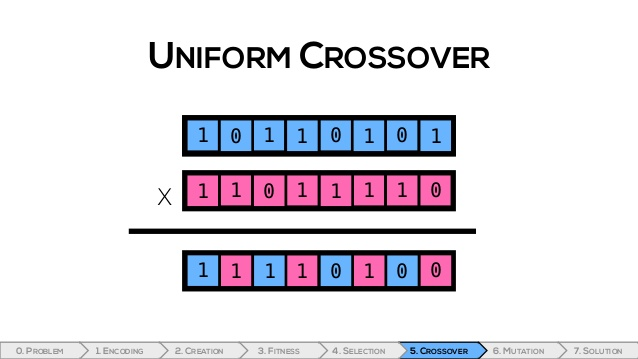

In [9]:
def crossover(father,mother):
  offspring = chromosome()
  for i in range(len(offspring.timetable)):
    #r = randint(0,1)
    if i % 2 == 0:
      offspring.timetable[i].time =  mother.timetable[i].time
      offspring.timetable[i].course_teacher = mother.timetable[i].course_teacher
      offspring.timetable[i].room = mother.timetable[i].room
    else:
      offspring.timetable[i].time =  father.timetable[i].time
      offspring.timetable[i].course_teacher = father.timetable[i].course_teacher
      offspring.timetable[i].room = father.timetable[i].room

  return offspring

**Mutation**

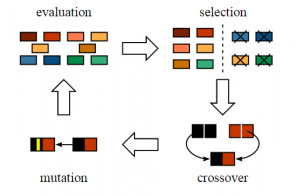

**Algorithm Implemented**


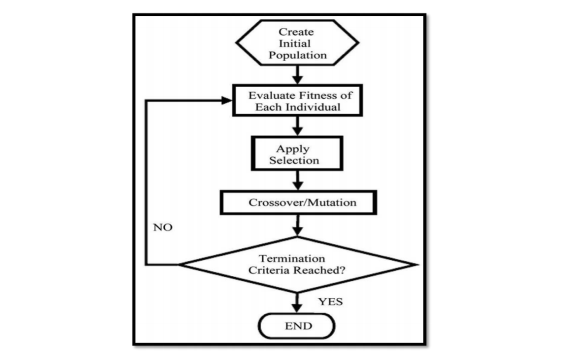

# Assumptions :

1.   Time slot is 3 hours 
2.   Room capacity is sufficient
3.   There are only 2 slots in the day
4.   Fitness with 100 value is maximum
5.   Penalty for time clash between courses is 5 times more than other penalties i-e 5 
6.   Penalty for soft constraint i-e unbalance invigilation duty is 0.5
7.   Penalty for hard constraints of teachers and rooms clash is 1

In [10]:
# Main Algorithm
def GA():
  i  = 1
  while True:
    if chromosomes[i].clashfree:
      #print(chromosomes[i])
      return chromosomes[i]
      
    print("Generation Number :- ",i , end= "     Fitness :-")
    chromosomes[i].calculate_fitness()
    print(chromosomes[i].fitness)
    if (chromosomes[i].fitness == 100 ):
      #print("Solution Found\n",chromosomes[i])
      return chromosomes[i]

    #pool = heapq.nlargest(50,chromosomes)
    fitnesses = []
    for chromo in chromosomes:
      fitnesses.append(chromo.fitness)

    parents = roulette_select(chromosomes,fitnesses,2)
    #parents = selection_by_tournament(chromosomes)
    #print(parents[0].fitness,parents[1].fitness)
    child = crossover(parents[0],parents[1])
    child.mutate(i)
    chromosomes.append(child)
    if (child.clashfree):
      #print("Solution Found\n",child)
      return child
    i+=1


In [11]:
best_timetable = GA()

Generation Number :-  1     Fitness :-1.4925373134328357
Generation Number :-  2     Fitness :-1.4184397163120568
Generation Number :-  3     Fitness :-1.550387596899225
Generation Number :-  4     Fitness :-1.9417475728155338
Generation Number :-  5     Fitness :-2.73972602739726
Generation Number :-  6     Fitness :-2.1052631578947367
Generation Number :-  7     Fitness :-2.1505376344086025
Generation Number :-  8     Fitness :-2.5974025974025974
Generation Number :-  9     Fitness :-2.941176470588235
Generation Number :-  10     Fitness :-3.0303030303030303
Generation Number :-  11     Fitness :-1.9230769230769231
Generation Number :-  12     Fitness :-1.639344262295082
Generation Number :-  13     Fitness :-2.4096385542168677
Generation Number :-  14     Fitness :-1.7391304347826086
Generation Number :-  15     Fitness :-1.4814814814814816
Generation Number :-  16     Fitness :-1.7391304347826086
Generation Number :-  17     Fitness :-1.7391304347826086
Generation Number :-  18    

Generation Number :-  176     Fitness :-1.8867924528301887
Generation Number :-  177     Fitness :-2.73972602739726
Generation Number :-  178     Fitness :-0.881057268722467
Generation Number :-  179     Fitness :-2.666666666666667
Generation Number :-  180     Fitness :-1.9417475728155338
Generation Number :-  181     Fitness :-2.1505376344086025
Generation Number :-  182     Fitness :-1.7543859649122806
Generation Number :-  183     Fitness :-1.4814814814814816
Generation Number :-  184     Fitness :-2.1052631578947367
Generation Number :-  185     Fitness :-1.5151515151515151
Generation Number :-  186     Fitness :-1.9230769230769231
Generation Number :-  187     Fitness :-1.3986013986013985
Generation Number :-  188     Fitness :-1.4925373134328357
Generation Number :-  189     Fitness :-1.9417475728155338
Generation Number :-  190     Fitness :-1.5873015873015872
Generation Number :-  191     Fitness :-1.694915254237288
Generation Number :-  192     Fitness :-1.1560693641618496
Ge

Generation Number :-  381     Fitness :-4.878048780487805
Generation Number :-  382     Fitness :-6.451612903225806
Generation Number :-  383     Fitness :-6.666666666666667
Generation Number :-  384     Fitness :-6.451612903225806
Generation Number :-  385     Fitness :-8.333333333333332
Generation Number :-  386     Fitness :-9.523809523809524
Generation Number :-  387     Fitness :-4.761904761904762
Generation Number :-  388     Fitness :-9.523809523809524
Generation Number :-  389     Fitness :-6.666666666666667
Generation Number :-  390     Fitness :-4.878048780487805
Generation Number :-  391     Fitness :-3.7735849056603774
Generation Number :-  392     Fitness :-6.451612903225806
Generation Number :-  393     Fitness :-10.0
Generation Number :-  394     Fitness :-9.523809523809524
Generation Number :-  395     Fitness :-9.090909090909092
Generation Number :-  396     Fitness :-2.7777777777777777
Generation Number :-  397     Fitness :-6.666666666666667
Generation Number :-  398

Generation Number :-  566     Fitness :-6.451612903225806
Generation Number :-  567     Fitness :-4.761904761904762
Generation Number :-  568     Fitness :-4.878048780487805
Generation Number :-  569     Fitness :-3.8461538461538463
Generation Number :-  570     Fitness :-6.25
Generation Number :-  571     Fitness :-6.451612903225806
Generation Number :-  572     Fitness :-4.545454545454546
Generation Number :-  573     Fitness :-4.878048780487805
Generation Number :-  574     Fitness :-3.8461538461538463
Generation Number :-  575     Fitness :-4.878048780487805
Generation Number :-  576     Fitness :-10.0
Generation Number :-  577     Fitness :-4.761904761904762
Generation Number :-  578     Fitness :-5.0
Generation Number :-  579     Fitness :-6.451612903225806
Generation Number :-  580     Fitness :-6.666666666666667
Generation Number :-  581     Fitness :-6.666666666666667
Generation Number :-  582     Fitness :-10.0
Generation Number :-  583     Fitness :-3.6363636363636362
Genera

Generation Number :-  742     Fitness :-10.0
Generation Number :-  743     Fitness :-4.545454545454546
Generation Number :-  744     Fitness :-5.0
Generation Number :-  745     Fitness :-6.666666666666667
Generation Number :-  746     Fitness :-5.714285714285714
Generation Number :-  747     Fitness :-3.225806451612903
Generation Number :-  748     Fitness :-6.451612903225806
Generation Number :-  749     Fitness :-6.666666666666667
Generation Number :-  750     Fitness :-6.451612903225806
Generation Number :-  751     Fitness :-5.714285714285714
Generation Number :-  752     Fitness :-8.333333333333332
Generation Number :-  753     Fitness :-4.651162790697675
Generation Number :-  754     Fitness :-6.25
Generation Number :-  755     Fitness :-5.714285714285714
Generation Number :-  756     Fitness :-6.451612903225806
Generation Number :-  757     Fitness :-6.25
Generation Number :-  758     Fitness :-6.25
Generation Number :-  759     Fitness :-3.9215686274509802
Generation Number :- 

Generation Number :-  913     Fitness :-6.0606060606060606
Generation Number :-  914     Fitness :-18.181818181818183
Generation Number :-  915     Fitness :-6.666666666666667
Generation Number :-  916     Fitness :-10.0
Generation Number :-  917     Fitness :-5.0
Generation Number :-  918     Fitness :-5.0
Generation Number :-  919     Fitness :-10.0
Generation Number :-  920     Fitness :-6.666666666666667
Generation Number :-  921     Fitness :-6.25
Generation Number :-  922     Fitness :-10.0
Generation Number :-  923     Fitness :-6.666666666666667
Generation Number :-  924     Fitness :-18.181818181818183
Generation Number :-  925     Fitness :-5.0
Generation Number :-  926     Fitness :-5.0
Generation Number :-  927     Fitness :-3.3333333333333335
Generation Number :-  928     Fitness :-4.651162790697675
Generation Number :-  929     Fitness :-6.666666666666667
Generation Number :-  930     Fitness :-6.666666666666667
Generation Number :-  931     Fitness :-3.278688524590164
Ge

Generation Number :-  1080     Fitness :-6.666666666666667
Generation Number :-  1081     Fitness :-5.0
Generation Number :-  1082     Fitness :-10.0
Generation Number :-  1083     Fitness :-20.0
Generation Number :-  1084     Fitness :-5.0
Generation Number :-  1085     Fitness :-4.651162790697675
Generation Number :-  1086     Fitness :-4.545454545454546
Generation Number :-  1087     Fitness :-6.451612903225806
Generation Number :-  1088     Fitness :-3.1746031746031744
Generation Number :-  1089     Fitness :-5.88235294117647
Generation Number :-  1090     Fitness :-6.666666666666667
Generation Number :-  1091     Fitness :-6.666666666666667
Generation Number :-  1092     Fitness :-5.88235294117647
Generation Number :-  1093     Fitness :-4.651162790697675
Generation Number :-  1094     Fitness :-3.1746031746031744
Generation Number :-  1095     Fitness :-3.9215686274509802
Generation Number :-  1096     Fitness :-3.7735849056603774
Generation Number :-  1097     Fitness :-5.0
Gene

Generation Number :-  1232     Fitness :-5.714285714285714
Generation Number :-  1233     Fitness :-3.3333333333333335
Generation Number :-  1234     Fitness :-6.451612903225806
Generation Number :-  1235     Fitness :-6.451612903225806
Generation Number :-  1236     Fitness :-4.878048780487805
Generation Number :-  1237     Fitness :-6.0606060606060606
Generation Number :-  1238     Fitness :-6.25
Generation Number :-  1239     Fitness :-4.761904761904762
Generation Number :-  1240     Fitness :-3.8461538461538463
Generation Number :-  1241     Fitness :-9.523809523809524
Generation Number :-  1242     Fitness :-6.666666666666667
Generation Number :-  1243     Fitness :-6.25
Generation Number :-  1244     Fitness :-4.0
Generation Number :-  1245     Fitness :-10.0
Generation Number :-  1246     Fitness :-10.0
Generation Number :-  1247     Fitness :-20.0
Generation Number :-  1248     Fitness :-6.25
Generation Number :-  1249     Fitness :-4.444444444444445
Generation Number :-  1250 

In [12]:
sorted_Time(best_timetable)  # prints timetable

Course     Teacher                        Room  Day 		-StartHours-Endhours     
+==========================================================================================+
CS302      Usman Ashraf                   5     Monday    	Section A 9AM-12PM 
CY2012     Hasan Mujtaba                  7     Monday    	Section A 2PM-5PM  
CS211      Shams Farooq                   1     Tuesday   	Section A 9AM-12PM 
SS111      Mehwish Hassan                 2     Tuesday   	Section A 2PM-5PM  
MT205      Mehreen Alam                   5     Wednesday 	Section A 9AM-12PM 
SE110      Asma Nisa                      7     Wednesday 	Section A 2PM-5PM  
CS328      Sadia Nauman                   3     Thursday  	Section A 9AM-12PM 
CS220      Waseem Shahzad                 1     Thursday  	Section A 2PM-5PM  
MT224      Sanaa Ilyas                    8     Friday    	Section A 2PM-5PM  
AI2011     Muhammad Usman                 8     Monday    	Section B 9AM-12PM 
MG220      Ayesha Bano               

In [13]:
print("Clashes Resolved :- " ,best_timetable.clashfree)
print("Total Days : ", int(len(time)/2))


Clashes Resolved :-  True
Total Days :  12


# Hard Constraints resolved : 6/6


# Soft Constraints resolved : 3/4

In [14]:
print("Unequal Duties for assigned teachers : ",best_timetable.UNBALANCE_DUTY)
print("Every Friday, there is break from 1pm-2pm")
print("No section can hold three consecutive classes.")


Unequal Duties for assigned teachers :  0
Every Friday, there is break from 1pm-2pm
No section can hold three consecutive classes.
